In [41]:
import findspark
findspark.init()

In [42]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spark-nlp") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5") \
    .getOrCreate()

In [43]:
# Check the SparkSession
spark

In [219]:
sc = spark.sparkContext
data = sc.wholeTextFiles("s3a://zihe-public/articles/AA/wiki_01")

In [220]:
import re
def get_id(x):
    pattern = "\<doc\sid\=\"(\d+)\"(.*)title\=\"(.*)\"\>"
    pattern_re = re.compile(pattern)
    matches = pattern_re.search(x)
    if not matches:
        return ""
    return matches[1]

def get_title(x):
    pattern = "\<doc\sid\=\"(\d+)\"(.*)title\=\"(.*)\"\>"
    pattern_re = re.compile(pattern)
    matches = pattern_re.search(x)
    if not matches:
        return ""
    return matches[3]

def get_content(x):
    pattern = "\<doc\sid\=\"(\d+)\"(.*)title\=\"(.*)\"\>\\n(.*?)\\n{2}"
    pattern_re = re.compile(pattern)
    matches = pattern_re.search(x)
    if not matches:
        return ""
    idx = matches.end(0)
    return x[idx:]

In [221]:
text = ""
get_content(text)

''

In [222]:
pages = data.flatMap(lambda x: (x[1].split('</doc>'))).map(lambda x : (get_id(x), get_title(x), get_content(x)))

In [223]:
pages = pages.toDF(["id","title","text"])

In [224]:
pages.select("title").show(1000, False)

+----------------------------------------+
|title                                   |
+----------------------------------------+
|Alaska                                  |
|Agriculture                             |
|Aldous Huxley                           |
|Ada                                     |
|Aberdeen (disambiguation)               |
|Algae                                   |
|Analysis of variance                    |
|Alkane                                  |
|Appellate procedure in the United States|
|Answer (law)                            |
|Appellate court                         |
|Arraignment                             |
|America the Beautiful                   |
|Assistive technology                    |
|Abacus                                  |
|Acid                                    |
|Asphalt                                 |
|American National Standards Institute   |
|Argument (disambiguation)               |
|Apollo 11                               |
|Apollo 8  

In [170]:
article = pages[pages['title'] == "Autism"]
#article.show()

In [171]:
type(pages)

pyspark.sql.dataframe.DataFrame

In [172]:
import nltk
# get the list of stopwords from nltk
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')
eng_stopwords.append('xxxx')
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer, 
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline

In [173]:
documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords)

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [174]:
pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

In [175]:
# transform text with the pipeline
equifax = pipeline.fit(article).transform(article)

In [176]:
# expand the "finished_clean_lemma" column so that the words are not in a list
from pyspark.sql.functions import explode, col

equifax_words = equifax.withColumn("exploded_text", explode(col("finished_clean_lemma")))

In [177]:
counts = equifax_words.groupby('exploded_text').count()

In [178]:
counts_pd = counts.toPandas()
counts_pd.sort_values(by=['count'], ascending=False)

,exploded_text,count
128,autism,161
938,child,67
1067,asd,47
904,autistic,45
462,may,43
...,...,...
618,different,1
619,goal,1
621,guideline,1
622,cost,1


In [179]:
counts_dic = {counts_pd.loc[i, 'exploded_text']: counts_pd.loc[i, 'count'] for i in range(counts_pd.shape[0])}

In [180]:
maximum_frequncy = max(counts_dic.values())

In [181]:
for word in counts_dic.keys():
    counts_dic[word] = (counts_dic[word]/maximum_frequncy)

In [182]:
equifax.select("finished_clean_lemma").show(10)

+--------------------+
|finished_clean_lemma|
+--------------------+
|[autism, developm...|
+--------------------+



In [183]:
article.limit(1)

DataFrame[id: string, title: string, text: string]

In [208]:
text = article.collect()[0].asDict()['text']

In [185]:
import nltk
#nltk.download('punkt')

In [186]:
#text

In [209]:
re.split('\n |\. ',text)

['Autism is a developmental disorder characterized by difficulties with social interaction and communication, and by restricted and repetitive behavior',
 "Parents often notice signs during the first three years of their child's life",
 'These signs often develop gradually, though some children with autism experience worsening in their communication and social skills after reaching developmental milestones at a normal pace.\nAutism is associated with a combination of genetic and environmental factors',
 'Risk factors during pregnancy include certain infections, such as rubella, toxins including valproic acid, alcohol, cocaine, pesticides, lead, and air pollution, fetal growth restriction, and autoimmune diseases',
 'Controversies surround other proposed environmental causes; for example, the vaccine hypothesis, which has been disproven',
 'Autism affects information processing in the brain and how nerve cells and their synapses connect and organize; how this occurs is not well understo

In [210]:
sentence_scores = {}
for sent in re.split('\n |\. |\.\s',text):
    for word in nltk.word_tokenize(sent.lower()):
        if word in counts_dic.keys():
            if sent not in sentence_scores.keys():
                sentence_scores[sent] = counts_dic[word]
            else:
                sentence_scores[sent] += counts_dic[word]

In [218]:
import heapq
summary_sentences = heapq.nlargest(5, sentence_scores, key=sentence_scores.get)

summary = '.\n\n'.join(summary_sentences)
print(summary)


The terminology of autism can be bewildering, with autism, Asperger syndrome and PDD-NOS often called the "autism spectrum disorders" (ASD) or sometimes the "autistic disorders", whereas autism itself is often called "autistic disorder", "childhood autism", or "infantile autism".


Of the five PDD forms, Asperger syndrome is closest to autism in signs and likely causes; Rett syndrome and childhood disintegrative disorder share several signs with autism, but may have unrelated causes; PDD not otherwise specified (PDD-NOS; also called "atypical autism") is diagnosed when the criteria are not met for a more specific disorder.

Organizations dedicated to promoting awareness of autism include Autism Speaks, Autism National Committee, and Autism Society of America.

Two are commonly used in autism research: the Autism Diagnostic Interview-Revised (ADI-R) is a semistructured parent interview, and the Autism Diagnostic Observation Schedule (ADOS) uses observation and interaction with the child

In [189]:
text = " ".join([" ".join(c['finished_clean_lemma']) for c in equifax.collect()])

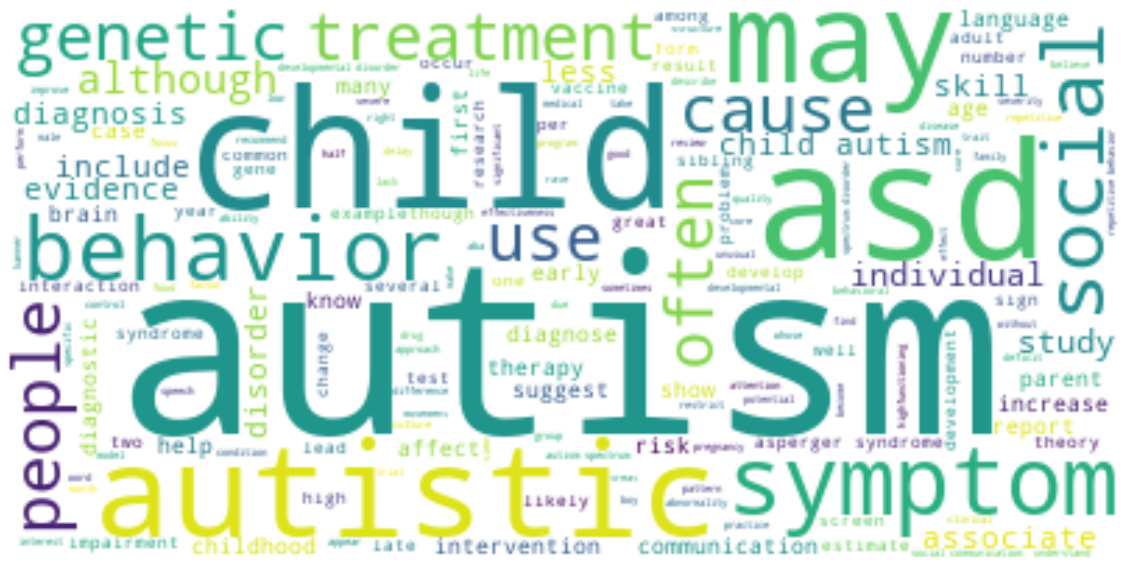

In [190]:
#pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
#% matplotlib inline

wordcloud_spam = WordCloud(background_color="white").generate(text)

# Lines 2 - 5
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

In [191]:
df_ngrams = equifax.withColumn("tokens", col("finished_clean_lemma"))

In [193]:
# N-gram Language Models 

from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline


def build_ngrams(inputCol="tokens", n=2):

    ngrams = [
        NGram(n=i, inputCol="tokens", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i))
        for i in range(1, n + 1)
    ]

    assembler = [VectorAssembler(
        inputCols=["{0}_counts".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]

    return Pipeline(stages=ngrams + vectorizers + assembler)


test_ngrams = build_ngrams().fit(df_ngrams).transform(df_ngrams) 

In [194]:
test_ngrams.show(5)

+---+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id| title|                text|            document|               token|          normalized|               lemma|         clean_lemma|finished_clean_lemma|              tokens|             1_grams|             2_grams|            1_counts|            2_counts|            features|
+---+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 25|Autism|Autism is a devel...|[[document, 0, 43...|[[token, 0, 5, Au...|[[token, 0, 5, au...|[[token, 0, 5, au...|[[token, 0, 5, au...|[aut

In [200]:
test_2grams = test_ngrams.withColumn("2_grams_key", explode(col("2_grams")))

In [206]:
test_2grams.show(3, False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
counts = equifax_words.groupby('exploded_text').count()

In [203]:
#test_2grams_df = test_2grams.toPandas()
#test_2grams_df

Py4JJavaError: An error occurred while calling o3224.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 96.0 failed 4 times, most recent failure: Lost task 0.3 in stage 96.0 (TID 1427, ip-172-31-93-233.ec2.internal, executor 26): ExecutorLostFailure (executor 26 exited caused by one of the running tasks) Reason: Container from a bad node: container_1587969744601_0005_01_000027 on host: ip-172-31-93-233.ec2.internal. Exit status: 52. Diagnostics: Exception from container-launch.
Container id: container_1587969744601_0005_01_000027
Exit code: 52
Stack trace: ExitCodeException exitCode=52: 
	at org.apache.hadoop.util.Shell.runCommand(Shell.java:972)
	at org.apache.hadoop.util.Shell.run(Shell.java:869)
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:1170)
	at org.apache.hadoop.yarn.server.nodemanager.DefaultContainerExecutor.launchContainer(DefaultContainerExecutor.java:235)
	at org.apache.hadoop.yarn.server.nodemanager.containermanager.launcher.ContainerLaunch.call(ContainerLaunch.java:299)
	at org.apache.hadoop.yarn.server.nodemanager.containermanager.launcher.ContainerLaunch.call(ContainerLaunch.java:83)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)


Container exited with a non-zero exit code 52
.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:2041)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2029)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2028)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2028)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:966)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:966)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:966)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2262)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2211)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2200)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:777)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:335)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:84)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:165)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:74)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.GeneratedMethodAccessor359.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [198]:
test_ngrams.select("2_grams", "2_counts").show(3, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------